분석할 데이터를 불러옵니다.

In [2]:
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd


rc('font', family='AppleGothic')
matplotlib.rcParams['axes.unicode_minus'] = False  
pd.options.display.max_columns = 40
data_path = "/Users/dongho/Downloads/MADUP_DS_dataset.csv"
df = pd.read_csv(data_path, skiprows=1)

데이터를 확인한 후, string 타입의 list를 list타입으로 변경합니다.

In [5]:
import ast

df['device_platforms'] = df['device_platforms'].map(lambda x: ast.literal_eval(x) if not pd.isna(x) else [])
df['publisher_platforms'] = df['publisher_platforms'].map(lambda x: ast.literal_eval(x) if not pd.isna(x) else [])
df['facebook_positions'] = df['facebook_positions'].map(lambda x: ast.literal_eval(x) if not pd.isna(x) else [])
df['instagram_positions'] = df['instagram_positions'].map(lambda x: ast.literal_eval(x) if not pd.isna(x) else [])	
df['interests'] = df['interests'].map(lambda x: x.split(', ') if not pd.isna(x) else [])

광고 성과 지표를 광고마다 계산하여 추가합니다.

In [44]:
df['CTR'] = df.apply(lambda row: int(row['link_click'])/int(row['impressions'])*100, axis=1)
df['CPM'] = df.apply(lambda row: int(row['spend'])/(row['impressions']/1000) * 100, axis=1)
df['CPC'] = df.apply(lambda row: int(row['spend'])/int(row['link_click']) if int(row['link_click']) else 1.007449e+06, axis=1)
df['CPA'] = df.apply(lambda row: int(row['spend']/(row['purchase']+row['view_content'])) if int(row['purchase']) else 71680.000000, axis=1)
df['CVR'] = df.apply(lambda row: (row['purchase'] + row['view_content'])/row['link_click'] if row['link_click'] else 0, axis=1)
df['ROAS'] = df.apply(lambda row: int(row['purchase_value'])/int(row['spend']) if row['spend'] else 0, axis=1)

광고 캠패인(adset_id)별 성과를 측정하기 위해, adset_id 별로 광고 성과 지표를 다시 계산합니다.

In [46]:
df_by_adset = []

for adset_id in set(df['adset_id']):
    ddf = df[df['adset_id'] == adset_id]
    data = ddf.iloc[0][df.columns[:23]].to_dict()
    for col in df.columns[24:]:
        data[col] = ddf[col].mean()
    df_by_adset.append(data)
    
ddf = pd.DataFrame(df_by_adset)

전체적인 CTR, impressions, link_click 분포를 확인하기 위해, 시각화를 해봅니다.  
상위 5%대에 높은 성과 데이터가 몰려있는것을 확인할 수 있습니다.

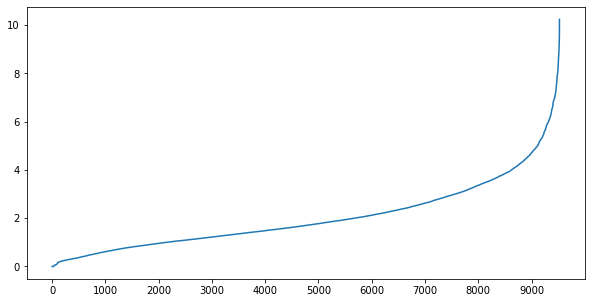

In [77]:
df['CTR'].sort_values().reset_index(drop=True).plot(figsize=(10,5))
plt.xticks(range(0,9526, 1000))
plt.show()

<AxesSubplot:>

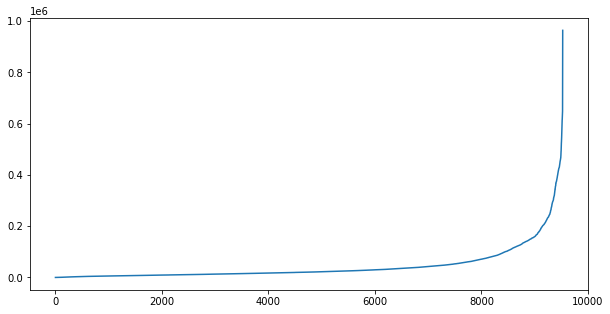

In [105]:
df.sort_values('impressions')['impressions'].reset_index(drop=True).plot(figsize=(10,5))

<AxesSubplot:>

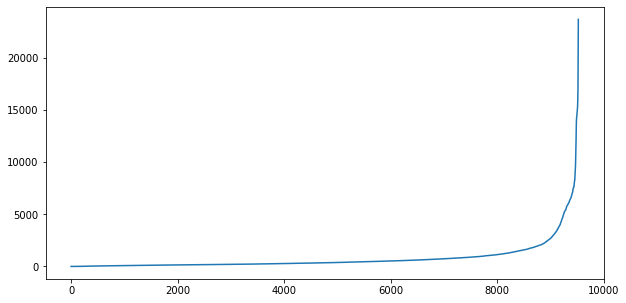

In [106]:
df.sort_values('link_click')['link_click'].reset_index(drop=True).plot(figsize=(10,5))

광고 성과가 종합적으로 가장 좋았던 캠페인 아이디의 CTR과 CPA 지표의 시간별 변화를 보기위해 시각화를 해봅니다.  
특별한 점은 없습니다.

(168.25, 52.75)

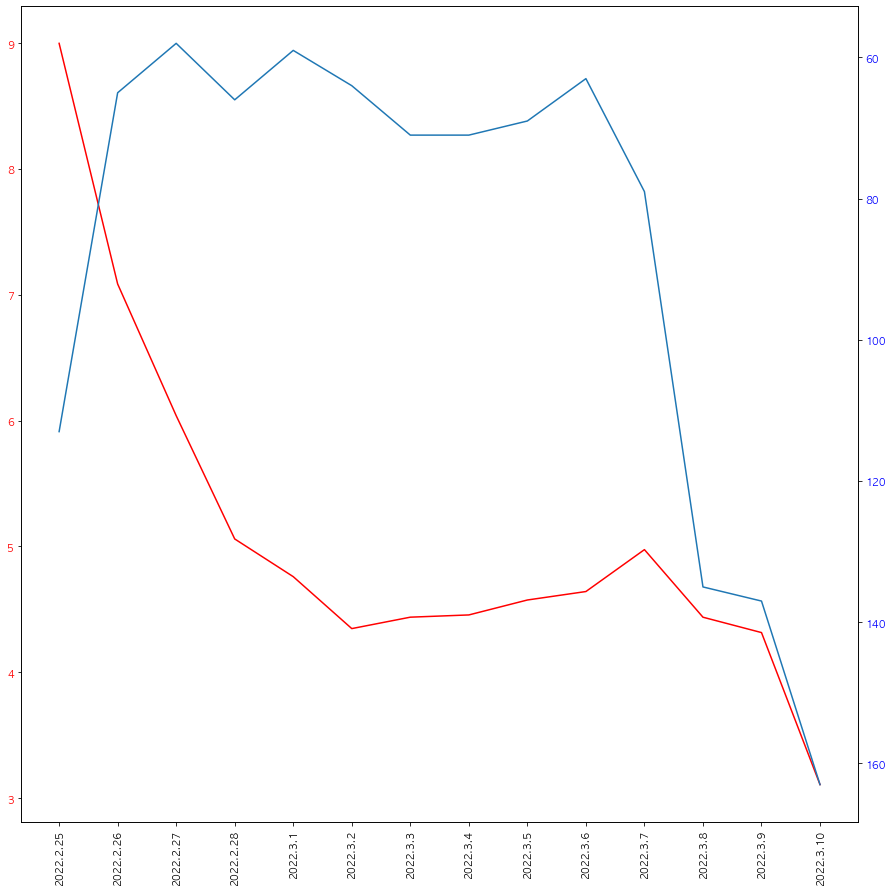

In [56]:
ROAS_5_list = list(set(df[df['ROAS'] > df['ROAS'].quantile(0.95)]['adset_id']))
CTR_by_date = df[df['adset_id']==609520315700]
CTR_by_date = CTR_by_date[['date', 'CTR','CPA']]
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(111)
ax1.plot(CTR_by_date['date'], CTR_by_date['CTR'], color = 'red')
ax1.tick_params(axis = 'y', labelcolor = 'red')
plt.xticks(rotation=90)

ax2 = ax1.twinx()
ax2.plot(CTR_by_date['date'], CTR_by_date['CPA'])
ax2.tick_params(axis = 'y', labelcolor = 'blue')
ax2.set_ylim(ax2.get_ylim()[::-1])
# ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)


CTR 상위 5%의 광고데이터들의 facebook_publisher와 instagram_publisher의 데이터 점유율을 확인합니다.  
Facebook_publisher에선, "feed"와 "story"의 점유를 확인할 수 있으며,  
Instagram_publusher에선 "stream"과 "explore"에 높은 점유를 확인할 수 있습니다.

In [60]:
facebook_postitions_set = {}
instagram_postitions_set = {}

ctru5df = ddf[ddf['CTR'] > ddf['CTR'].quantile(0.95)]

for row in ctru5df.itertuples():
    for v in row.facebook_positions:
        if v not in facebook_postitions_set:
            facebook_postitions_set[v] = 1
        else:
            facebook_postitions_set[v] += 1
            

for row in ctru5df.itertuples():
    for v in row.instagram_positions:
        if v not in instagram_postitions_set:
            instagram_postitions_set[v] = 1
        else:
            instagram_postitions_set[v] += 1
            
print(facebook_postitions_set)
print(instagram_postitions_set)

{'feed': 44, 'story': 22, 'video_feeds': 2, 'search': 13, 'marketplace': 1, 'instant_article': 3, 'groups_feed': 1}
{'stream': 56, 'story': 28, 'explore': 51, 'shop': 18}


입력받은 DataFrame의 Column별 점유율을 확인할 수 있는 함수를 만듭니다.

In [49]:
from collections import Counter

col_filter = ['custom target', 'lookalike target', 'exclude target', 'targeting_optimization','daily budget','lifetime_budget','campagin_id',' objective', 'bid_amount', 'adset_id', 'ad_start_time', 'age_max','age_min','set_device_platforms','publisher_platforms','family_status','spend','impressions','link_click','page_engagement','view_content','purchase','purchase_value','date','CTR','CPM','CPC','CPA','CVR','ROAS']

def get_describe_by_col(input_df):
    for col in input_df.columns:
        if col in col_filter:
            continue
        if type(input_df[col].values[0]) == list:
            globals()[f'set_{col}'] = {}
            for l in input_df[col].values:
                for v in l:
                    if v not in globals()[f'set_{col}']:
                        globals()[f'set_{col}'][v] = 1
                    else :
                        globals()[f'set_{col}'][v] += 1
            print(sorted(globals()[f'set_{col}'].items(), key=lambda item: item[1], reverse=True))
        else:
            print(col, ":", Counter(input_df[col]))
        print('\n')

In [13]:
df.columns

Index(['campagin_id', 'objective', 'bid_strategy', 'bid_amount', 'buying_type',
       'adset_id', 'ad_start_time', 'daily budget', 'lifetime_budget',
       'optimization_goal', 'custom_event_type', 'age_max', 'age_min',
       'device_platforms', 'publisher_platforms', 'facebook_positions',
       'instagram_positions', 'interests', 'family_status', 'custom target',
       'lookalike target', 'exclude target', 'targeting_optimization', 'date',
       'spend', 'impressions', 'link_click', 'page_engagement', 'view_content',
       'purchase', 'purchase_value', 'CTR', 'CPM', 'CPC', 'CPA', 'CVR',
       'ROAS'],
      dtype='object')

In [54]:
#성과 상위 10% 이상인 그룹
# get_describe_by_col(df[(df['CTR'] > df['CTR'].quantile(0.9)) & (df['ROAS'] > df['ROAS'].quantile(0.9)) & (df['CPA'] < df['CPA'].quantile(0.1))])
get_describe_by_col(ddf[(ddf['CTR'] > ddf['CTR'].quantile(0.8)) & (ddf['ROAS'] > ddf['ROAS'].quantile(0.8)) & (ddf['CPA'] < ddf['CPA'].quantile(0.2))])

objective : Counter({'LINK_CLICKS': 8, 'CONVERSIONS': 5, 'PRODUCT_CATALOG_SALES': 4})


bid_strategy : Counter({'LOWEST_COST_WITHOUT_CAP': 17})


buying_type : Counter({'AUCTION': 17})


optimization_goal : Counter({'LINK_CLICKS': 15, 'OFFSITE_CONVERSIONS': 2})


custom_event_type : Counter({nan: 12, '"PURCHASE"': 5})


[('mobile', 17), ('desktop', 14)]


[('feed', 17), ('search', 12), ('marketplace', 2), ('story', 2), ('instant_article', 1)]


[('stream', 17), ('explore', 17), ('shop', 12), ('story', 2)]


[('온라인 쇼핑', 9), ('쇼핑몰', 8), ('쿠폰', 8), ('할인점', 8), ('남성복', 7), ('선글라스', 7), ('신발', 7), ('여성복', 7), ('의류', 7), ('보석', 6), ('핸드백', 6), ('명품', 6), ('부티크', 6), ('향수', 6), ('헤어 제품', 6), ('화장품', 6), ('전자상거래', 5), ('아동복', 5), ('미용실', 5), ('스파', 4), ('가구', 2), ('문신', 2), ('쇼핑 및 패션', 1), ('DIY', 1), ('가전 제품', 1), ('정원 가꾸기', 1), ('집 수리/인테리어', 1), ('골프', 1), ('골프 채널', 1), ('골프공', 1), ('골프장', 1), ('골프채', 1), ('전자제품', 1), ('취미', 1), ('패션 액세서리', 1), ('장난감', 1), ('데스크톱 컴퓨터', 1), ('스마트폰', 1), ('오디오

In [55]:
get_describe_by_col(ddf[(ddf['CTR'] < ddf['CTR'].quantile(0.8)) & (ddf['ROAS'] < ddf['ROAS'].quantile(0.8)) & (ddf['CPA'] > ddf['CPA'].quantile(0.2))])

objective : Counter({'LINK_CLICKS': 467, 'CONVERSIONS': 128, 'PRODUCT_CATALOG_SALES': 11, 'VIDEO_VIEWS': 10, 'APP_INSTALLS': 2})


bid_strategy : Counter({'LOWEST_COST_WITHOUT_CAP': 572, 'LOWEST_COST_WITH_BID_CAP': 46})


buying_type : Counter({'AUCTION': 618})


optimization_goal : Counter({'LINK_CLICKS': 573, 'LANDING_PAGE_VIEWS': 24, 'THRUPLAY': 10, 'OFFSITE_CONVERSIONS': 9, 'APP_INSTALLS': 2})


custom_event_type : Counter({nan: 575, '"PURCHASE"': 40, '"ADD_TO_CART"': 3})


[('mobile', 616), ('desktop', 484)]


[('feed', 547), ('search', 314), ('story', 133), ('video_feeds', 68), ('instant_article', 50), ('marketplace', 14), ('right_hand_column', 10), ('instream_video', 4), ('groups_feed', 2)]


[('stream', 613), ('explore', 589), ('shop', 360), ('story', 268)]


[('온라인 쇼핑', 353), ('쇼핑몰', 282), ('의류', 265), ('화장품', 260), ('남성복', 242), ('여성복', 241), ('쿠폰', 233), ('할인점', 230), ('신발', 220), ('명품', 212), ('헤어 제품', 210), ('선글라스', 209), ('부티크', 204), ('향수', 194), ('핸드백', 172), ('전자상거래', 

In [53]:
ddf[(ddf['CTR'] > ddf['CTR'].quantile(0.8)) & (ddf['ROAS'] > ddf['ROAS'].quantile(0.8)) & (ddf['CPA'] < ddf['CPA'].quantile(0.2))]

,campagin_id,objective,bid_strategy,bid_amount,buying_type,adset_id,ad_start_time,daily budget,lifetime_budget,optimization_goal,custom_event_type,age_max,age_min,device_platforms,publisher_platforms,facebook_positions,instagram_positions,interests,family_status,custom target,lookalike target,exclude target,targeting_optimization,spend,impressions,link_click,page_engagement,view_content,purchase,purchase_value,CTR,CPM,CPC,CPA,CVR,ROAS
236,319102905700,CONVERSIONS,LOWEST_COST_WITHOUT_CAP,NaN,AUCTION,360907575700,2022.1.24 10:00,NaN,"""1851852""",LINK_CLICKS,"""PURCHASE""",34,18,"[mobile, desktop]","[facebook, instagram]","[feed, search]","[stream, explore]",[],NaN,NaN,app_open_3%,NaN,"""expansion_all""",2.119495e+05,33829.272727,1126.000000,1142.454545,743.000000,127.636364,9.367432e+06,3.431318,6.541405e+05,191.160774,248.909091,0.795361,49.780609
288,128290945700,LINK_CLICKS,LOWEST_COST_WITHOUT_CAP,NaN,AUCTION,129663795700,2021.12.22 10:00,#VALUE!,"""5520347""",LINK_CLICKS,NaN,40,20,"[mobile, desktop]","[facebook, instagram]","[feed, search]","[stream, explore, shop]","[온라인 쇼핑, 전자상거래]",NaN,NaN,NaN,NaN,"""none""",5.033400e+05,117220.000000,3908.000000,3976.909091,2253.909091,252.909091,2.032770e+07,3.543647,4.398748e+05,125.624862,194.272727,0.645692,42.813673
331,319102925700,LINK_CLICKS,LOWEST_COST_WITHOUT_CAP,NaN,AUCTION,303507845700,2022.1.17 10:00,NaN,"""1851851""",LINK_CLICKS,NaN,34,18,"[mobile, desktop]","[facebook, instagram]","[feed, search]","[stream, explore, shop]","[쇼핑 및 패션, 전자상거래]",NaN,NaN,NaN,NaN,"""expansion_all""",1.985046e+05,37524.571429,1004.571429,1042.071429,526.857143,187.928571,1.590848e+07,3.044993,6.009710e+05,230.767471,267.857143,0.849739,79.222492
390,558283135900,PRODUCT_CATALOG_SALES,LOWEST_COST_WITHOUT_CAP,NaN,AUCTION,558283145900,2021.10.26 17:26,#VALUE!,NaN,OFFSITE_CONVERSIONS,"""PURCHASE""",49,18,"[mobile, desktop]","[facebook, instagram]","[feed, marketplace]","[stream, explore]",[],NaN,NaN,NaN,NaN,"""none""",1.670708e+06,180393.233333,5813.544444,6199.011111,4641.211111,943.577778,7.169930e+07,3.253425,9.286877e+05,288.831915,301.444444,0.964990,43.453992
454,319102925700,LINK_CLICKS,LOWEST_COST_WITHOUT_CAP,NaN,AUCTION,399162405700,2022.1.27 15:52,NaN,"""1574074""",LINK_CLICKS,NaN,40,18,"[mobile, desktop]","[facebook, instagram]","[feed, search]","[stream, explore, shop]","[DIY, 가구, 가전 제품, 남성복, 보석, 선글라스, 쇼핑몰, 신발, 아동복, ...",NaN,NaN,NaN,NaN,"""expansion_all""",1.430976e+05,23752.636364,843.181818,874.090909,569.727273,74.181818,5.790588e+06,3.432688,5.935953e+05,175.930544,212.000000,0.884814,77.841823
576,394453365900,PRODUCT_CATALOG_SALES,LOWEST_COST_WITHOUT_CAP,NaN,AUCTION,436953465900,2021.10.12 19:47,#VALUE!,NaN,OFFSITE_CONVERSIONS,"""PURCHASE""",49,18,"[mobile, desktop]","[facebook, instagram]","[feed, marketplace]","[stream, explore]",[],NaN,NaN,NaN,NaN,"""none""",2.544524e+06,293574.077778,10622.155556,11032.144444,8883.455556,3567.777778,2.680492e+08,3.725982,8.182825e+05,224.311908,188.588889,1.217177,143.124601
580,311072455700,LINK_CLICKS,LOWEST_COST_WITHOUT_CAP,NaN,AUCTION,672670235700,2022.2.11 15:11,NaN,"""1296296""",LINK_CLICKS,NaN,54,25,[mobile],"[facebook, instagram]","[feed, story]","[stream, story, explore]","[골프, 골프 채널, 골프공, 골프장, 골프채, 남성복, 명품, 보석, 부티크, 선...",NaN,NaN,NaN,NaN,"""none""",4.382713e+04,8529.933333,347.266667,352.600000,177.733333,20.866667,1.538629e+06,4.205581,5.061555e+05,123.059120,216.000000,0.627924,43.189943
630,128290945700,LINK_CLICKS,LOWEST_COST_WITHOUT_CAP,NaN,AUCTION,401737325700,2022.1.31 10:00,NaN,"""2400000""",LINK_CLICKS,NaN,34,18,"[mobile, desktop]","[facebook, instagram]","[feed, search]","[stream, explore, shop]","[남성복, 명품, 미용실, 부티크, 선글라스, 쇼핑몰, 신발, 여성복, 온라인 쇼핑...",NaN,NaN,NaN,NaN,"""none""",1.372414e+05,19774.310345,592.206897,599.172414,405.068966,92.172414,7.388034e+06,3.151880,6.834911e+05,227.568147,286.586207,0.830238,52.743307
639,319102925700,LINK_CLICKS,LOWEST_COST_WITHOUT_CAP,NaN,AUCTION,165592855700,2021.12.27 10:00,NaN,"""1481481""

In [9]:
df[(df['CTR'] > df['CTR'].quantile(0.9)) & (df['ROAS'] > df['ROAS'].quantile(0.9)) & (df['CPA'] < df['CPA'].quantile(0.1))].mean()

/var/folders/9d/ddwhsc8n72g466gn1jhdj3480000gn/T/ipykernel_30318/903439605.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df[(df['CTR'] > df['CTR'].quantile(0.9)) & (df['ROAS'] > df['ROAS'].quantile(0.9)) & (df['CPA'] < df['CPA'].quantile(0.1))].mean()


campagin_id         4.051126e+11
bid_amount                   NaN
adset_id            5.415152e+11
age_max             4.660417e+01
age_min             1.862500e+01
lookalike target             NaN
exclude target               NaN
spend               7.182841e+05
impressions         9.960498e+04
link_click          4.312500e+03
page_engagement     4.470771e+03
view_content        3.639333e+03
purchase            1.565312e+03
purchase_value      1.187567e+08
CTR                 5.054887e+00
CPM                 7.147466e+05
CPC                 1.439866e+02
CPA                 1.307083e+02
CVR                 1.109445e+00
ROAS                1.569761e+02
dtype: float64

In [10]:
 1.569761e+02

156.9761

In [14]:
# get_describe_by_col(df[(df['CTR'] > df['CTR'].quantile(0.8)) & (df['CPA'] < df['CPA'].quantile(0.2))])
# get_describe_by_col(df[df['ROAS'] > df['ROAS'].quantile(0.95)])
# get_describe_by_col(df[df['CVR'] > df['CVR'].quantile(0.95)])
get_describe_by_col(df[(df['CTR'] < df['CTR'].quantile(0.9)) & (df['ROAS'] < df['ROAS'].quantile(0.9)) & (df['CPA'] > df['CPA'].quantile(0.1))])

objective : Counter({'LINK_CLICKS': 4638, 'CONVERSIONS': 1799, 'PRODUCT_CATALOG_SALES': 551, 'APP_INSTALLS': 181, 'VIDEO_VIEWS': 76, 'REACH': 1, 'BRAND_AWARENESS': 1})


bid_strategy : Counter({'LOWEST_COST_WITHOUT_CAP': 7201, 'LOWEST_COST_WITH_BID_CAP': 46})


buying_type : Counter({'AUCTION': 7247})


optimization_goal : Counter({'LINK_CLICKS': 6312, 'OFFSITE_CONVERSIONS': 594, 'APP_INSTALLS': 181, 'LANDING_PAGE_VIEWS': 82, 'THRUPLAY': 76, 'REACH': 1, 'AD_RECALL_LIFT': 1})


custom_event_type : Counter({nan: 6251, '"PURCHASE"': 910, '"ADD_TO_CART"': 86})


[('mobile', 7066), ('desktop', 5472)]


[('feed', 6421), ('search', 3882), ('story', 1415), ('video_feeds', 520), ('marketplace', 231), ('instant_article', 206), ('groups_feed', 49), ('right_hand_column', 32), ('instream_video', 25)]


[('stream', 7047), ('explore', 6834), ('shop', 4260), ('story', 2874), ('reels', 2)]


[('온라인 쇼핑', 3575), ('쇼핑몰', 3116), ('의류', 3007), ('할인점', 2915), ('쿠폰', 2881), ('화장품', 2785), ('남성복', 2700), ('신발'

In [89]:
df['interests']

0                                    
1                                    
2                                    
3                                    
4                                    
                    ...              
9521                                 
9522                                 
9523    [쇼핑몰, 온라인 쇼핑, 향수, 헤어 제품, 화장품]
9524                 [소프트웨어 개발, 웹 개발]
9525                 [소프트웨어 개발, 웹 개발]
Name: interests, Length: 9526, dtype: object